# CEIA - Análisis de Datos
## Trabajo Práctico Final

• Christopher Sebastian, Charaf Herrera 

• Cecilia Azul, Villanueva

• Maria Fabiana, Cid

• Niels Pacheco

# 4. Análisis de datos: Uso de taxis Yellow Cab en USA en el año 2020. 

•  ¿Existe una manera de caracterizar los lugares más recurrentes parainicio/fin de viaje? 

•  ¿Cómo son los viajes típicamente en distancia y tiempo? 


In [3]:
import pyarrow.parquet as pq
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler,scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
import geopandas as gpd
from shapely.geometry import LineString

plt.style.use('ggplot')

## 4.1 Carga de Datos

Tomamos los datos preprocesados y limpios, incorporamos la información de las Zonas de Taxis.

In [4]:
#Taxi Zones
zones=pd.read_csv(r"taxi_zone_lookup.csv")
zones.head(2)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone


In [5]:
#Dataset de viajes preprocesado
df=pq.read_table(r"dataset\dataset_cleaned.parquet")
df=df.to_pandas()

In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,1.0,0,238,75,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,0.0
1,1,2020-07-01 00:03:19,2020-07-01 00:25:43,1.0,9.50,1.0,0,138,216,1,26.5,0.5,0.5,0.00,0.0,0.3,27.80,0.0
2,2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,1.0,0,230,88,2,18.5,0.5,0.5,0.00,0.0,0.3,22.30,2.5
3,2,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,1.0,0,88,232,1,8.0,0.5,0.5,2.36,0.0,0.3,14.16,2.5
4,2,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,1.0,0,37,17,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,0.0


In [7]:
df.shape

(2681969, 18)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2681969 entries, 0 to 2681968
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     int64         
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: datetime64[us](2), 

In [9]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,2.681969e+06,2681969,2681969,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06,2.681969e+06
mean,1.658039e+00,2020-08-22 19:22:06.351659,2020-08-22 19:34:20.221418,1.405281e+00,1.975827e+00,1.015611e+00,7.894946e-03,1.648598e+02,1.612640e+02,1.319006e+00,9.337083e+00,1.051277e+00,4.985871e-01,1.588063e+00,1.248571e-02,2.997586e-01,1.429574e+01,2.268883e+00
min,1.000000e+00,2008-12-31 23:05:27,2008-12-31 23:25:04,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2020-07-31 23:33:25,2020-07-31 23:46:31,1.000000e+00,9.500000e-01,1.000000e+00,0.000000e+00,1.130000e+02,1.070000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.055000e+01,2.500000e+00
50%,2.000000e+00,2020-08-25 18:32:00,2020-08-25 18:42:03,1.000000e+00,1.570000e+00,1.000000e+00,0.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,8.000000e+00,5.000000e-01,5.000000e-01,1.660000e+00,0.000000e+00,3.000000e-01,1.330000e+01,2.500000e+00
75%,2.000000e+00,2020-09-15 10:56:40,2020-09-15 11:09:30,1.000000e+00,2.550000e+00,1.000000e+00,0.000000e+00,2.360000e+02,2.360000e+02,2.000000e+00,1.150000e+01,2.500000e+00,5.000000e-01,2.560000e+00,0.000000e+00,3.000000e-01,1.716000e+01,2.500000e+00
max,2.000000e+00,2020-10-07 18:10:39,2020-10-07 18:27:01,9.000000e+00,4.847745e+04,9.900000e+01,1.000000e+00,2.650000e+02,2.650000e+02,5.000000e+00,3.027000e+01,1.278000e+01,3.300000e+00,3.000000e+01,2.750000e+01,3.000000e-01,3.080000e+01,2.500000e+00
std,4.743666e-01,NaN,NaN,1.054712e+00,2.963609e+01,7.591092e-01,8.850208e-02,6.765240e+01,7.124947e+01,4.907238e-01,4.629677e+00,1.222269e+00,2.687859e-02,1.486293e+00,2.813319e-01,8.506392e-03,5.246334e+00,7.241373e-01


In [10]:
df.isna().sum().sort_values(ascending=False).head(10)

VendorID                 0
tpep_pickup_datetime     0
total_amount             0
improvement_surcharge    0
tolls_amount             0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
payment_type             0
dtype: int64

In [11]:
(df.isna().sum() / df.shape[0]*100).sort_values(ascending=False).head(10)

VendorID                 0.0
tpep_pickup_datetime     0.0
total_amount             0.0
improvement_surcharge    0.0
tolls_amount             0.0
tip_amount               0.0
mta_tax                  0.0
extra                    0.0
fare_amount              0.0
payment_type             0.0
dtype: float64

In [12]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,1.0,0,238,75,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,0.0
1,1,2020-07-01 00:03:19,2020-07-01 00:25:43,1.0,9.50,1.0,0,138,216,1,26.5,0.5,0.5,0.00,0.0,0.3,27.80,0.0
2,2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,1.0,0,230,88,2,18.5,0.5,0.5,0.00,0.0,0.3,22.30,2.5
3,2,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,1.0,0,88,232,1,8.0,0.5,0.5,2.36,0.0,0.3,14.16,2.5
4,2,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,1.0,0,37,17,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,0.0


## 4.2 Nuevos Features

En esta sección creamos nuevos features a partir de los existentes.

- Año, mes, día 
- Hora de inicio y hora de fin de viaje
- Dia de la semana: Lunes, Martes, Miercoles, etc. de inicio y fin de viaje.
- Duración del viaje
 

In [13]:
df['fecha_pickup']=df.tpep_pickup_datetime.dt.date
df['fecha_dropoff']=df.tpep_dropoff_datetime.dt.date
df["anio_pickup"] = df.tpep_pickup_datetime.dt.year # extraer el año de la fecha
df["anio_dropoff"] = df.tpep_dropoff_datetime.dt.year # extraer el año de la fecha
df["mes_pickup"]  = df.tpep_pickup_datetime.dt.month # extraer el mes de la fecha
df["mes_dropoff"] = df.tpep_dropoff_datetime.dt.month # extraer el mes de la fecha
df["nmes_pickup"] = df["mes_pickup"].replace({1:"Enero",2:"Febrero",3:"Marzo",4:"Abril",5:"Mayo",6:"Junio",7:"Julio",8:"Agosto",9:"Septiembre",10:"Octubre",11:"Noviembre",12:"Diciembre"}) # reemplazar el número por el nombre del mes
df["nmes_dropoff"] = df["mes_dropoff"].replace({1:"Enero",2:"Febrero",3:"Marzo",4:"Abril",5:"Mayo",6:"Junio",7:"Julio",8:"Agosto",9:"Septiembre",10:"Octubre",11:"Noviembre",12:"Diciembre"}) # reemplazar el número por el nombre del mes
df["dia_pickup"]  = df.tpep_pickup_datetime.dt.day # extraer el dia de la fecha
df["dia_dropoff"] = df.tpep_dropoff_datetime.dt.day # extraer el dia de la fecha
df["tdia_pickup"] = df.tpep_pickup_datetime.dt.dayofweek # extraer el día de la semana de la fecha
df["tdia_dropoff"] = df.tpep_dropoff_datetime.dt.dayofweek # extraer el día de la semana de la fecha
df["ndia_pickup"]= df["tdia_pickup"].replace({0:"Lunes",1:"Martes",2:"Miércoles",3:"Jueves",4:"Viernes",5:"Sábado",6:"Domingo"}) # reemplazar el número por el nombre del dia
df["ndia_dropoff"]= df["tdia_dropoff"].replace({0:"Lunes",1:"Martes",2:"Miércoles",3:"Jueves",4:"Viernes",5:"Sábado",6:"Domingo"}) # reemplazar el número por el nombre del dia
df["hora_pickup"] = df.tpep_pickup_datetime.dt.hour # extraer la hora de la fecha   
df["hora_dropoff"] = df.tpep_dropoff_datetime.dt.hour # extraer la hora de la fecha
df["duracion"] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() # calcular la duración del viaje en segundos


In [14]:
# Lista de días de fin de semana
fin_de_semana = ['Sábado', 'Domingo']

# Crear la nueva columna 'es_fin_de_semana'
df['es_fin_de_semana'] = df['ndia_pickup'].apply(lambda x: 1 if x in fin_de_semana else 0)

Realizamos un join entre el dataset de viajes y la informacion de las zonas de taxis (para la ubicación de inico y fin de viaje).

In [15]:
df = df.merge(zones, how="left", left_on="PULocationID", right_on="LocationID")
df.rename(columns={"Borough":"Borough_pickup","Zone":"Zone_pickup","service_zone":"service_zone_pickup"}, inplace=True)
df = df.merge(zones, how="left", left_on="DOLocationID", right_on="LocationID")
df.rename(columns={"Borough":"Borough_dropoff","Zone":"Zone_dropoff","service_zone":"service_zone_dropoff"}, inplace=True) 
df.drop(columns=["LocationID_x","LocationID_y"], inplace=True)
df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,hora_pickup,hora_dropoff,duracion,es_fin_de_semana,Borough_pickup,Zone_pickup,service_zone_pickup,Borough_dropoff,Zone_dropoff,service_zone_dropoff
0,1,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,1.0,0,238,75,2,...,0,0,487.0,0,Manhattan,Upper West Side North,Yellow Zone,Manhattan,East Harlem South,Boro Zone
1,1,2020-07-01 00:03:19,2020-07-01 00:25:43,1.0,9.50,1.0,0,138,216,1,...,0,0,1344.0,0,Queens,LaGuardia Airport,Airports,Queens,South Ozone Park,Boro Zone
2,2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,1.0,0,230,88,2,...,0,0,853.0,0,Manhattan,Times Sq/Theatre District,Yellow Zone,Manhattan,Financial District South,Yellow Zone


## 4.3 Limpieza de datos

Verificamos que los datos de los nuevos features no sean inconsistentes.

In [16]:
df[['duracion','trip_distance','fare_amount']].describe()

,duracion,trip_distance,fare_amount
count,2.681969e+06,2.681969e+06,2.681969e+06
mean,7.338698e+02,1.975827e+00,9.337083e+00
std,1.963539e+04,2.963609e+01,4.629677e+00
min,-3.162024e+07,0.000000e+00,0.000000e+00
25%,3.260000e+02,9.500000e-01,6.000000e+00
50%,5.200000e+02,1.570000e+00,8.000000e+00
75%,7.920000e+02,2.550000e+00,1.150000e+01
max,2.438450e+05,4.847745e+04,3.027000e+01


<Axes: xlabel='duracion'>

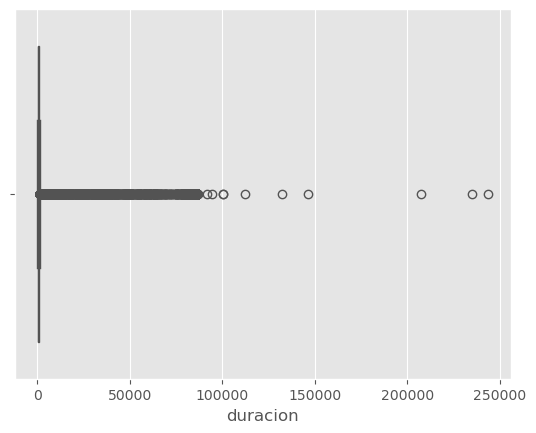

In [17]:
sns.boxplot(x="duracion",data=df[df['duracion']> 0])

<Axes: xlabel='trip_distance'>

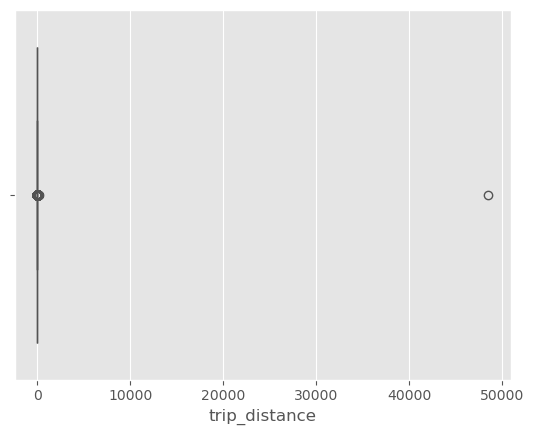

In [18]:
sns.boxplot(x="trip_distance",data=df[df['trip_distance']> 0])

<Axes: xlabel='fare_amount'>

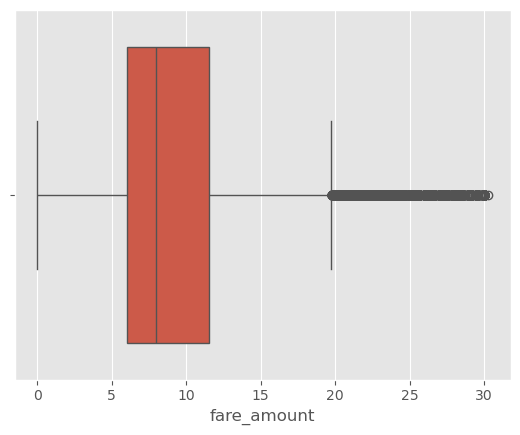

In [19]:
sns.boxplot(x="fare_amount",data=df[df['fare_amount']> 0])

Se eliminan registros con datos inconsistentes en los nuevos features:

- Duración menor a 0 segundos y mayor a una hora
- Año de inicio de viaje distinto a 2020
- Mes de inicio de viaje igual a 7,8 o 9 (Julio, Agosto, Septiembre)
- Mes de fin de viaje mayor o igual a 7 (Julio)
- Viajes con distancia negativa o mayor a 2000 (millas)
- Monto de Tarifa menor a 1000

In [20]:
df = df[(df['duracion'] > 0) & (df['duracion'] < 3600)]
df = df[(df['anio_pickup'] ==2020) & (df['anio_dropoff'] ==2020)]
df = df[(df['mes_pickup'] >= 7) & (df['mes_dropoff'] <= 9)]
df = df[(df['mes_dropoff'] >= 7)]
df = df[(df['trip_distance'] >0) & (df['trip_distance']< 2000 )]
df=  df[(df['fare_amount'] < 1000)] 

Se eliminó el 3% de los registros.

In [21]:
df.shape

(2625466, 42)

## 4.4 Cantidades de Viajes

Se estuadiará la cantidad de viajes en relacion al dia de la semana y a la hora de inicio. 

Se calcularán los totales y la mediana para cada día.

In [22]:
#Cantidad de viajes totales por cada día de la semana
total_viajes_dia = df.groupby(['fecha_pickup','ndia_pickup']).size().groupby(level=1).sum().reset_index(name='total_viajes')

print(total_viajes_dia)

  ndia_pickup  total_viajes
0     Domingo        245018
1      Jueves        419088
2       Lunes        356550
3      Martes        412881
4   Miércoles        459980
5      Sábado        323937
6     Viernes        408012


In [23]:
#Mediana de la Cantidad de viajes en cada día de la semana
mediana_viajes_dia = df.groupby(['fecha_pickup','ndia_pickup']).size().groupby('ndia_pickup').median(round(0)).reset_index(name='mediana_viajes')

print(mediana_viajes_dia)

  ndia_pickup  mediana_viajes
0     Domingo         17380.0
1      Jueves         30522.0
2       Lunes         26714.0
3      Martes         30269.0
4   Miércoles         30607.0
5      Sábado         23459.0
6     Viernes         30341.0


In [24]:
#Cantidad de viajes totales por cada día y hora de la semana
total_viajes_dia_hora = df.groupby(['fecha_pickup','ndia_pickup','hora_pickup']).size().groupby(['ndia_pickup','hora_pickup']).sum().reset_index(name='total_viajes')

print(total_viajes_dia_hora)

    ndia_pickup  hora_pickup  total_viajes
0       Domingo            0          8074
1       Domingo            1          5110
2       Domingo            2          3127
3       Domingo            3          1636
4       Domingo            4          1090
..          ...          ...           ...
163     Viernes           19         26152
164     Viernes           20         19089
165     Viernes           21         14422
166     Viernes           22         13889
167     Viernes           23         12795

[168 rows x 3 columns]


In [25]:
#Mediana de la Cantidad de viajes en cada día y hora de la semana
mediana_viajes_dia_hora = df.groupby(['fecha_pickup','ndia_pickup','hora_pickup']).size().groupby(['ndia_pickup','hora_pickup']).median(round(0)).reset_index(name='mediana_viajes')

print(mediana_viajes_dia_hora)

    ndia_pickup  hora_pickup  mediana_viajes
0       Domingo            0           566.0
1       Domingo            1           367.0
2       Domingo            2           222.0
3       Domingo            3           125.0
4       Domingo            4            78.0
..          ...          ...             ...
163     Viernes           19          1859.0
164     Viernes           20          1430.0
165     Viernes           21          1120.0
166     Viernes           22          1122.0
167     Viernes           23           980.0

[168 rows x 3 columns]


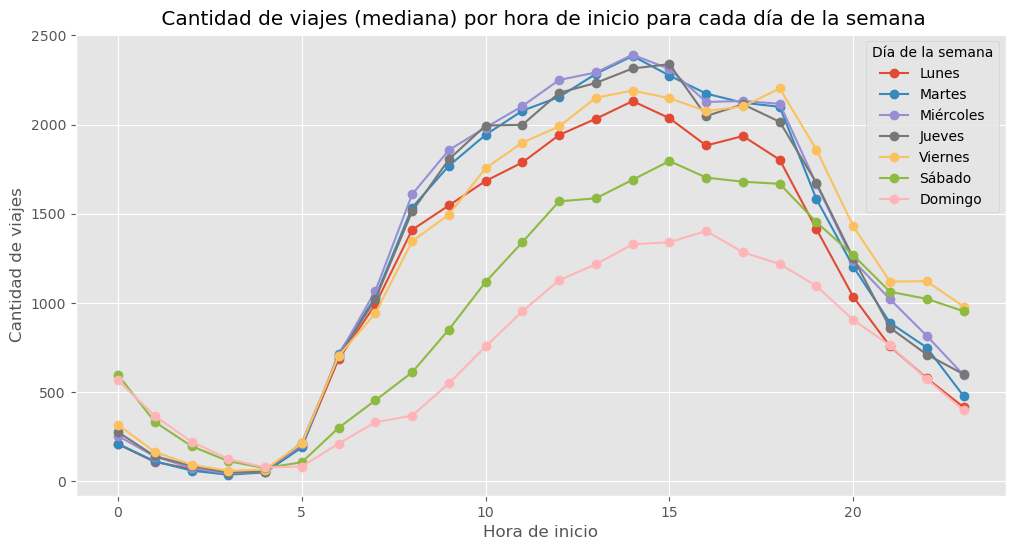

In [26]:
df_grouped = mediana_viajes_dia_hora.groupby(['ndia_pickup', 'hora_pickup'],observed=False )['mediana_viajes'].sum().unstack('ndia_pickup')

orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_grouped = df_grouped[orden_dias]

# Genera el gráfico
df_grouped.plot(kind='line', figsize=(12, 6), marker='o')

# Añade etiquetas y título
plt.xlabel('Hora de inicio')
plt.ylabel('Cantidad de viajes')
plt.title(' Cantidad de viajes (mediana) por hora de inicio para cada día de la semana')
plt.legend(title='Día de la semana')

# Muestra el gráfico
plt.show()

Se observa que en lineas generales el comportamiento es similar para los dias de semana y fines de semana. Particularmente se ve que los sabados y domingos tienen menor cantidad de viajes en relacion a los dias de semana. Los martes, miércoles y jueves son los dias "parecidos" en términos de cantidad de viajes por hora.
En relacion con el horario de inicio de viaje se puede ver que la cantidad aumenta desde la madrugada hasta las 15 hs donde se produce un pico maximo. Luego comineza a disminuir. la cantidad hacia la noche. 

In [27]:
mediana_duracion_viajes_dia_hora = (df.groupby(['ndia_pickup', 'hora_pickup'])['duracion'].median()/60).reset_index(name='mediana_duracion_viajes')
mediana_duracion_viajes_dia_hora

,ndia_pickup,hora_pickup,mediana_duracion_viajes
0,Domingo,0,8.550000
1,Domingo,1,8.891667
2,Domingo,2,8.583333
3,Domingo,3,8.108333
4,Domingo,4,7.691667
...,...,...,...
163,Viernes,19,8.516667
164,Viernes,20,8.300000
165,Viernes,21,8.400000
166,Viernes,22,8.533333


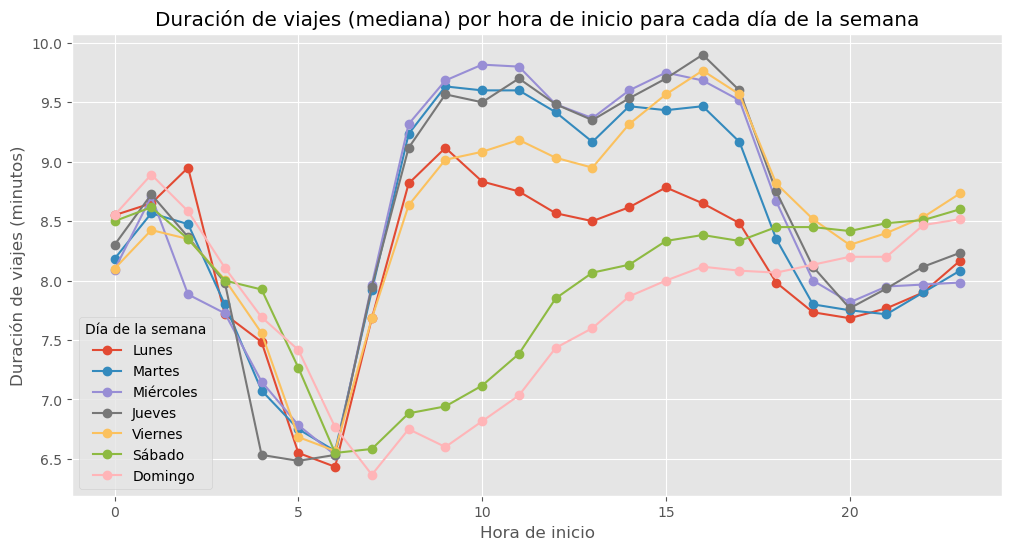

In [28]:
df_grouped = mediana_duracion_viajes_dia_hora.groupby(['ndia_pickup', 'hora_pickup'],observed=False )['mediana_duracion_viajes'].sum().unstack('ndia_pickup')

orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_grouped = df_grouped[orden_dias]

# Genera el gráfico
df_grouped.plot(kind='line', figsize=(12, 6), marker='o')

# Añade etiquetas y título
plt.xlabel('Hora de inicio')
plt.ylabel('Duración de viajes (minutos)')
plt.title('Duración de viajes (mediana) por hora de inicio para cada día de la semana')
plt.legend(title='Día de la semana')

# Muestra el gráfico
plt.show()

En relación a la duración de los viajes se observa que entre las 8 y las 11 de la mañana, como entre las 14 y las 17 hs se producen los picos maximos, conincidente con las horas de mayor tráfico. Los días lunes los viajes tienen menor duración que el resto de los dias de la semana y los fines de semana (sabado y domingo) presentena un comoportamiento similar donde la duracion de los viajes aumenta desde las 5 am hasta las 23 hs.

In [29]:
mediana_distancia_viajes_dia_hora = (df.groupby(['ndia_pickup', 'hora_pickup'])['trip_distance'].median()/60).reset_index(name='mediana_distancia_viajes')
mediana_distancia_viajes_dia_hora

,ndia_pickup,hora_pickup,mediana_distancia_viajes
0,Domingo,0,0.035000
1,Domingo,1,0.038500
2,Domingo,2,0.036667
3,Domingo,3,0.035750
4,Domingo,4,0.033667
...,...,...,...
163,Viernes,19,0.027500
164,Viernes,20,0.027833
165,Viernes,21,0.029167
166,Viernes,22,0.031333


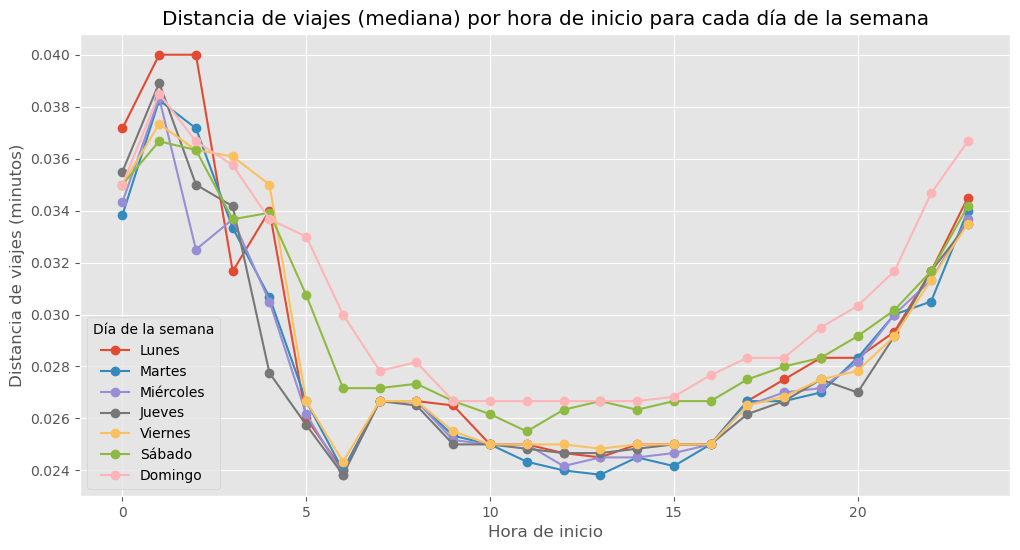

In [30]:
df_grouped = mediana_distancia_viajes_dia_hora.groupby(['ndia_pickup', 'hora_pickup'],observed=False )['mediana_distancia_viajes'].sum().unstack('ndia_pickup')

orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_grouped = df_grouped[orden_dias]

# Genera el gráfico
df_grouped.plot(kind='line', figsize=(12, 6), marker='o')

# Añade etiquetas y título
plt.xlabel('Hora de inicio')
plt.ylabel('Distancia de viajes (minutos)')
plt.title('Distancia de viajes (mediana) por hora de inicio para cada día de la semana')
plt.legend(title='Día de la semana')

# Muestra el gráfico
plt.show()

Se puede observar que durante la madrugada (0 a 5 hs) los viajes tienen mayor distancia. Durante la mañana y la tarde los viajes suelen ser mas cortos en terminos de distancia y aumentan a partir de las 18 hs.

In [31]:
total_viajes_OD=df.groupby(['PULocationID','Borough_pickup','Zone_pickup','DOLocationID','Borough_dropoff','Zone_dropoff']).size().reset_index(name='total_viajes').sort_values(by='total_viajes',ascending=False)
total_viajes_OD

,PULocationID,Borough_pickup,Zone_pickup,DOLocationID,Borough_dropoff,Zone_dropoff,total_viajes
10801,237,Manhattan,Upper East Side South,236,Manhattan,Upper East Side North,20190
10674,236,Manhattan,Upper East Side North,237,Manhattan,Upper East Side South,17479
10673,236,Manhattan,Upper East Side North,236,Manhattan,Upper East Side North,14356
10802,237,Manhattan,Upper East Side South,237,Manhattan,Upper East Side South,14234
11031,239,Manhattan,Upper West Side South,238,Manhattan,Upper West Side North,9988
...,...,...,...,...,...,...,...
1353,42,Manhattan,Central Harlem North,132,Queens,JFK Airport,1
3033,75,Manhattan,East Harlem South,228,Brooklyn,Sunset Park West,1
4015,95,Queens,Forest Hills,141,Manhattan,Lenox Hill West,1
3028,75,Manhattan,East Harlem South,217,Brooklyn,South Williamsburg,1


## 4.5 Analisis de Datos con Geopandas

Se utiliza el archivo shapefile disponible en el [sitio web](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) .

In [32]:
# Cargar el shapefile
shapefile_path = r"taxi_zones\taxi_zones.shp"

gdf = gpd.read_file(shapefile_path)
#gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

# Mostrar las primeras filas del GeoDataFrame
gdf.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


Agrupamos la cantidad de viajes por zona de recogida (pickup) y entrega de pasajeros (dropoff)par aidentificar las zonas de mayor demanda.

In [33]:
# Cantidad de Viajes Pickups y Dropoff por Zona
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, gdf, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
pu_zone = pu_zone.to_crs(epsg=3857)

do_zone = df.groupby(['DOLocationID'], as_index=False).size()
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, gdf, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = do_zone.to_crs(epsg=3857)

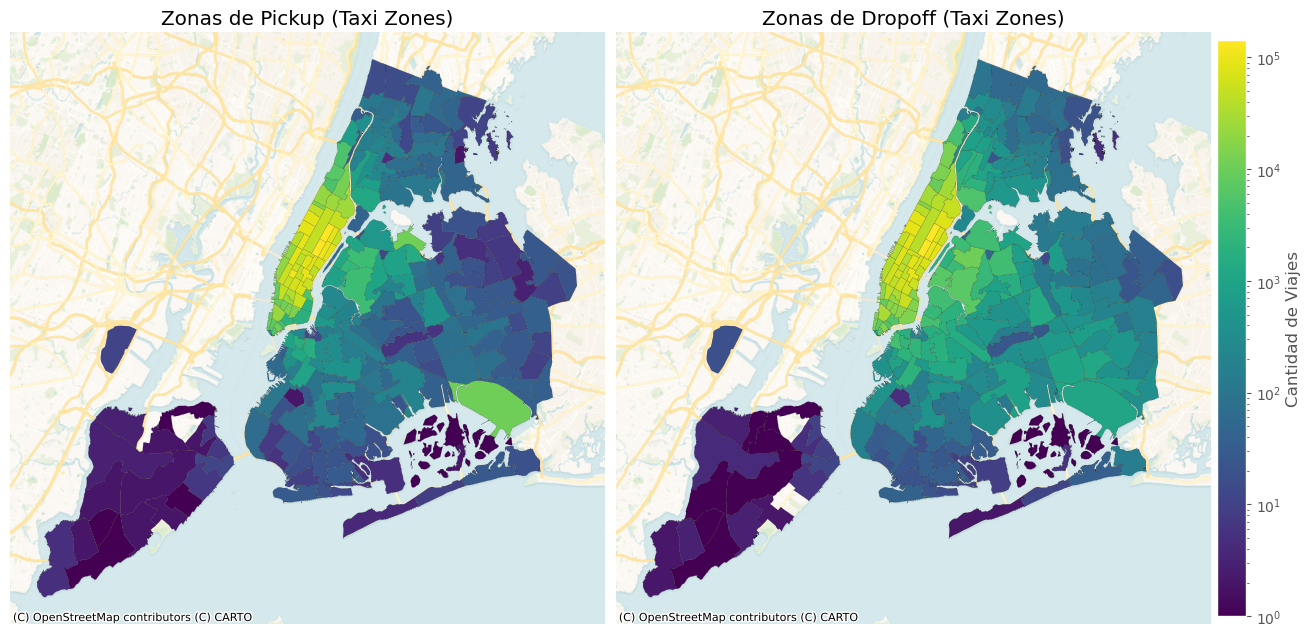

In [34]:
# Plot de las zonas de pickup y dropoff
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)

#Pickups
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
axs[0] = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10),norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='viridis', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.VoyagerNoLabels)

#Dropoffs
vmin, vmax = do_zone['size'].min(), do_zone['size'].max()
axs[1] = do_zone.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10), norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='viridis', legend=False, ax=axs[1])
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.VoyagerNoLabels)

axs[0].set_title('Zonas de Pickup (Taxi Zones)')
axs[1].set_title('Zonas de Dropoff (Taxi Zones)')
axs[0].set_axis_off()
axs[1].set_axis_off()

# Barra de Color
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Cantidad de Viajes')

plt.show()

Se puede ver que la zona de Manhattan es donde comienzan y terminan la mayor cantidad de viajes.

In [35]:
#gdf = gpd.read_file(shapefile_path)
#gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

# Calcular el centroide de cada polígono
gdf['centroid'] = gdf.geometry.centroid

# Extraer las coordenadas del centroide
gdf['centroid_x'] = gdf.centroid.x
gdf['centroid_y'] = gdf.centroid.y


In [36]:
df = gpd.GeoDataFrame(pd.merge(df, gdf, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
df = df.rename(columns={'geometry':'geometry_pickup','centroid_x':'centroid_pickup_x','centroid_y':'centroid_pickup_y',
                        'Shape_Leng':'Shape_Leng_pickup','Shape_Area':'Shape_Area_pickup','zone':'zone_pickup','borough':'borough_pickup',
                        'centroid':'centroid_pickup','OBJECTID':'OBJECTID_pickup'}) 
                        
df = gpd.GeoDataFrame(pd.merge(df, gdf, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
df = df.rename(columns={'geometry':'geometry_dropoff','centroid_x':'centroid_dropoff_x','centroid_y':'centroid_dropoff_y',
                        'Shape_Leng':'Shape_Leng_dropoff','Shape_Area':'Shape_Area_dropoff','zone':'zone_dropoff','borough':'borough_dropoff',
                        'centroid':'centroid_dropoff','OBJECTID':'OBJECTID_dropoff'}) 


In [37]:
total_viajes_OD=df.groupby(['PULocationID','Borough_pickup','Zone_pickup','OBJECTID_pickup', 'Shape_Leng_pickup',
                            'Shape_Area_pickup', 'zone_pickup', 'borough_pickup', 'geometry_pickup',
                            'centroid_pickup', 'centroid_pickup_x', 'centroid_pickup_y',
                            'DOLocationID','Borough_dropoff','Zone_dropoff','OBJECTID_dropoff', 'Shape_Leng_dropoff', 'Shape_Area_dropoff',
                            'zone_dropoff', 'borough_dropoff', 'geometry_dropoff',
                            'centroid_dropoff', 'centroid_dropoff_x', 'centroid_dropoff_y']).size().reset_index(name='total_viajes').sort_values(by='total_viajes',ascending=False)
total_viajes_OD.head(2)

,PULocationID,Borough_pickup,Zone_pickup,OBJECTID_pickup,Shape_Leng_pickup,Shape_Area_pickup,zone_pickup,borough_pickup,geometry_pickup,centroid_pickup,...,OBJECTID_dropoff,Shape_Leng_dropoff,Shape_Area_dropoff,zone_dropoff,borough_dropoff,geometry_dropoff,centroid_dropoff,centroid_dropoff_x,centroid_dropoff_y,total_viajes
10845,237,Manhattan,Upper East Side South,237,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",POINT (993769.024 219305.828),...,236,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",POINT (996155.387 223613.754),996155.386766,223613.753576,20190
10717,236,Manhattan,Upper East Side North,236,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",POINT (996155.387 223613.754),...,237,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",POINT (993769.024 219305.828),993769.023714,219305.827826,17479


In [38]:
from shapely.geometry import LineString
# Crear una nueva columna con las líneas origen-destino
total_viajes_OD['linea_origen_destino'] = total_viajes_OD.apply( lambda row: LineString([row['centroid_pickup'], row['centroid_dropoff']]), axis=1)

total_viajes_OD.head(2)

,PULocationID,Borough_pickup,Zone_pickup,OBJECTID_pickup,Shape_Leng_pickup,Shape_Area_pickup,zone_pickup,borough_pickup,geometry_pickup,centroid_pickup,...,Shape_Leng_dropoff,Shape_Area_dropoff,zone_dropoff,borough_dropoff,geometry_dropoff,centroid_dropoff,centroid_dropoff_x,centroid_dropoff_y,total_viajes,linea_origen_destino
10845,237,Manhattan,Upper East Side South,237,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",POINT (993769.024 219305.828),...,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",POINT (996155.387 223613.754),996155.386766,223613.753576,20190,LINESTRING (993769.0237137815 219305.827825552...
10717,236,Manhattan,Upper East Side North,236,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",POINT (996155.387 223613.754),...,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",POINT (993769.024 219305.828),993769.023714,219305.827826,17479,LINESTRING (996155.3867656847 223613.753576024...


Se representan los centros de cada zona con un punto rojo y con aristas azules las conexiones entre zonas de pickup y dropoff.

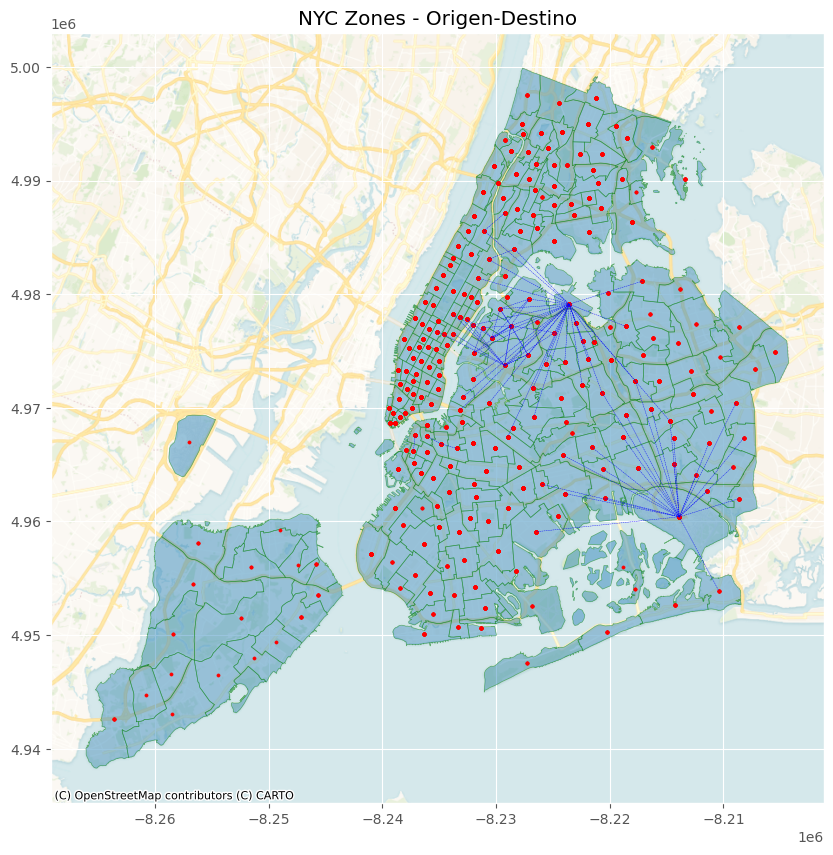

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import contextily as ctx


gdf_centroides = gpd.GeoDataFrame(total_viajes_OD, geometry='centroid_pickup', crs='EPSG:2263')  
gdf_centroides = gdf_centroides.to_crs(epsg=3857) # Convertir CRS a EPSG:3857

#gdf_lineas = gpd.GeoDataFrame(total_viajes_OD[total_viajes_OD['total_viajes']>100], geometry='linea_origen_destino', crs='EPSG:2263')  # Ajusta el CRS inicial si es necesario
gdf_lineas = gpd.GeoDataFrame(total_viajes_OD[(total_viajes_OD['Borough_pickup']!='Manhattan') & (total_viajes_OD['total_viajes']>100)], geometry='linea_origen_destino', crs='EPSG:2263')  # Ajusta el CRS inicial si es necesario
gdf_lineas = gdf_lineas.to_crs(epsg=3857) # Convertir CRS a EPSG:3857

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10,10))
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)
gdf.plot(ax=ax, edgecolor='green', alpha=0.5)

# Plotear las líneas origen-destino
gdf_lineas.plot(ax=ax, color='blue', linestyle='--', linewidth=0.3)

# Plotear los centroides
gdf_centroides.plot(ax=ax, color='red', marker='o', markersize=5)

# Añadir el mapa base de contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:3857')

# Añadir título
ax.set_title('NYC Zones - Origen-Destino')

# Mostrar el gráfico
plt.show()


Se filtraron los origienes-destino con mas de 100 viajes entres sí, sin considerar Manhattan como zona de inicio.

Se destacan principalmente dos zonas de Queens:

- 132	Queens	JFK Airport	

- 138	Queens	LaGuardia Airport	